# Банки — Сегментация пользователей по потреблению

## Описание проекта

### Задача**:**

Необходимо проанализировать данные о клиентах регионального банка и сегментировать их по количеству потребляемых продуктов. Заказчик — менеджер по продукту. Проект включает:

- Исследовательский анализ данных
- Сегментирование пользователей на основе данных о количестве потребляемых продуктов
- Формулировка и проверка статистических гипотез.    

## Загрузка данных

In [1]:
pip install phik

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from phik.report import plot_correlation_matrix
from scipy import stats as st
import numpy as np
import math as mth
from tqdm import tqdm

In [3]:
pd.options.display.float_format = '{:.2f}'.format

In [4]:
sns.set_palette('Paired')

In [5]:
try: 
    df = pd.read_csv('bank_dataset.csv') # локальный путь
except FileNotFoundError:
    df = pd.read_csv('/datasets/bank_dataset.csv') # яндексовский путь

In [6]:
df.sample(10, random_state=0) # вывод 5 рандомных строк

,userid,score,City,Gender,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
9394,15658489,597,Ростов Великий,Ж,35,8,131101.04,1,1,1,192852.67,0
898,15697436,523,Ярославль,Ж,40,2,102967.41,1,1,0,128702.10,1
2398,15676613,706,Рыбинск,Ж,42,8,95386.82,1,1,1,75732.25,0
5906,15788359,788,Ярославль,М,32,4,112079.58,1,0,0,89368.59,0
2343,15808638,706,Ростов Великий,М,38,5,163034.82,2,1,1,135662.17,0
8225,15846878,670,Рыбинск,Ж,57,3,175575.95,2,1,0,99061.75,1
5506,15739764,590,Рыбинск,М,34,0,65812.35,2,0,1,160346.30,0
6451,15765319,636,Рыбинск,Ж,29,6,157576.47,2,1,1,101102.39,0
2670,15803182,598,Ярославль,Ж,64,9,NaN,1,0,1,13181.37,1
3497,15631680,456,Ярославль,Ж,63,1,165350.61,2,0,0,140758.07,1


### **Описание данных:**

Датасет содержит данные о клиентах банка «Метанпром». Банк располагается в Ярославле и областных городах: Ростов Великий и Рыбинск. Данные были взяты в некий временной момент и в случае ушедших клиентов, это их состояние и баланс перед закрытием счета.

Колонки:

- `userid` — идентификатор пользователя,
- `score` — баллы кредитного скоринга (чем выше балл, тем надежнее клиент)
- `City` — город,
- `Gender` — пол,
- `Age` — возраст,
- `Objects` — количество объектов в собственности (значимые для банка объекты собственности в случае чего которые можно взять в залог)
- `Balance` — баланс на счёте,
- `Products` — количество продуктов, которыми пользуется клиент,
- `CreditCard` — есть ли кредитная карта,
- `Loyalty` — активный клиент,
- `estimated_salary` — заработная плата клиента,
- `Churn` — ушёл или нет.

### Общая информация по датасету

In [7]:
df.columns=df.columns.str.lower()

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   city              10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   objects           10000 non-null  int64  
 6   balance           6383 non-null   float64
 7   products          10000 non-null  int64  
 8   creditcard        10000 non-null  int64  
 9   loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


In [9]:
print('duplicates:', df.duplicated().sum()) # вывод количества дубликатов

duplicates: 0


Мы ознакомились с данными:
- В нашем датасете информация о 10000 пользователей и 12 признаках по каждому.
- Тип данных в столбце gender (пол) необходимо будет заменить на целочисленный.
- Для удобства работы мы преобразовали названия столбцов (все названия теперь написаны строчными буквами). 
- Дубликатов не было обнаружено
- Обнаружены пропуски в Balance — баланс на счёте.

## Исследовательский анализ данных (EDA)

### Предобработка данных: Замена типа данных и обработка дубликатов 

Дубликатов мы не обнаружили, поэтому здесь только заменим данные в столбце gender (пол).

In [10]:
df['gender'] = df['gender'].map({'М': 0, 'Ж': 1})

### Оценка общей картины. Портрет клиента банка
- Средние значения и стандартные отклонения признаков
    - метод describe() для всех переменных
    - графики распределения для переменных
- Общие представления о клиентах которые пользуется продуктами банка (до сегментации): возраст, доход, пользование картой, балл кредитного скоринга и т.д.

In [11]:
cols_ru_name = ['скоринг', 'пол', 'возраст', 'объекты', 'балланс', 'продукты', 'карта', 'активность', 'зарплата', 'отток']
portrait=df.describe().drop('userid', axis=1).drop('count')
portrait.columns=cols_ru_name
portrait

,скоринг,пол,возраст,объекты,балланс,продукты,карта,активность,зарплата,отток
mean,650.53,0.45,38.92,5.01,119827.49,1.53,0.71,0.52,100090.24,0.20
std,96.65,0.50,10.49,2.89,30095.06,0.58,0.46,0.50,57510.49,0.40
min,350.00,0.00,18.00,0.00,3768.69,1.00,0.00,0.00,11.58,0.00
25%,584.00,0.00,32.00,3.00,100181.98,1.00,0.00,0.00,51002.11,0.00
50%,652.00,0.00,37.00,5.00,119839.69,1.00,1.00,1.00,100193.91,0.00
75%,718.00,1.00,44.00,7.00,139512.29,2.00,1.00,1.00,149388.25,0.00
max,850.00,1.00,92.00,10.00,250898.09,4.00,1.00,1.00,199992.48,1.00


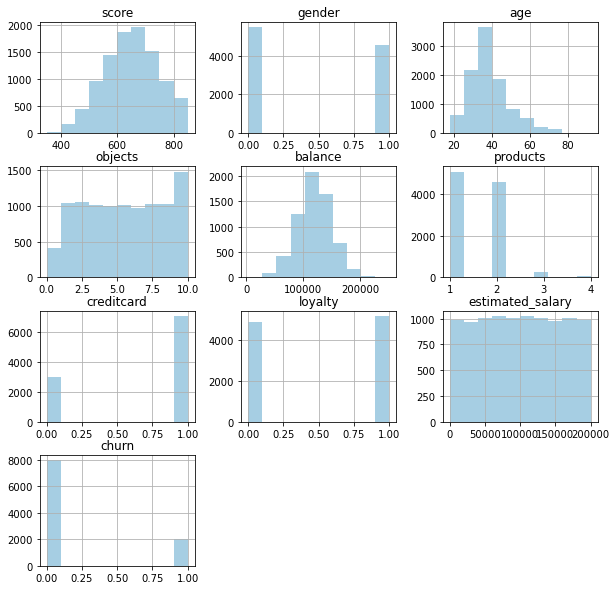

In [12]:
df.drop('userid', axis=1).hist(figsize = (10,10)); 

In [13]:
df['city'].value_counts(normalize=True)

Ярославль        0.50
Ростов Великий   0.25
Рыбинск          0.25
Name: city, dtype: float64

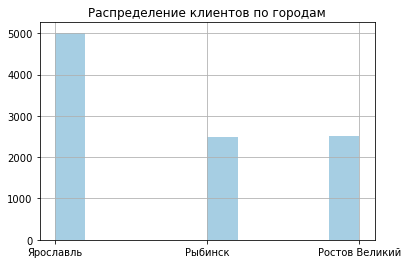

In [14]:
df['city'].hist()
plt.title("Распределение клиентов по городам")
plt.show()

Посмотрим также на диаграммы размаха для возраста, баланса и зарплаты.

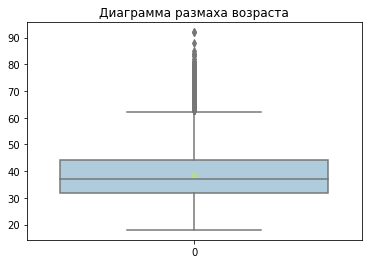

In [15]:
sns.boxplot(data=df['age'], showmeans=True)
plt.title("Диаграмма размаха возраста")
plt.show()

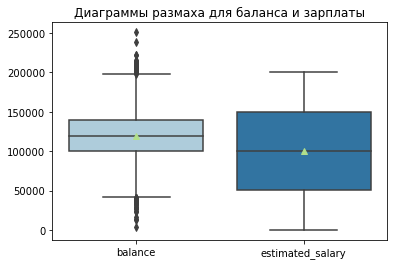

In [16]:
sns.boxplot(data=df[['balance', 'estimated_salary']], showmeans=True)
plt.title("Диаграммы размаха для баланса и зарплаты")
plt.show()

Средний баланс только немного выше средней зарплаты (и совпадает с медианой в обоих случаях), примерно 120 тысяч к 100, но там больше выбросов и меньше размах. И баланс и зарплата по нашим данным в большинстве своем не превышают 200 тысяч.

На данном этапе мы можем составить общий портрет пользователя нашего банка.

- У нас примерно поровну клиентов обоих полов (45% женщин), 
- Им от 18 до 92 лет, средний возраст 39 лет. 
- Пользователи имеют от 1 до 4 продуктов. Среднее число продуктов - 1.53, медианное - 1, то есть половина наших клиентов имеет в пользовании только один продукт, а три четверти не более двух.
- 71 % клиентов обладают кредитной картой
- 52 % клиентов являются активными 
- В среднем у них  в собственности находится пять объектов, всего может быть от нуля до десяти. 
- Средний балл кредитного скоринга 650, при этом минимум 350 и максимум 850
- 20% клиентов попали в отток, то есть ушли из банка
- Средняя заработная плата клиента 100 000, что также практически совпадает с медианным. Однако есть минимальная зарплата в 11.58, что, возможно, является ошибкой и требует удаления.
- Средний баланс на счету у клиентов около 120 000, что практически совпадает с медианным. Минимум около 3000, и нет нулевых значений. Однако, здесь есть много пропусков, которые нам предстоит проанализировать. Также на диаграмме размаха мы видим присутствие выбросов.
- Половина клиентов из Ярославля, по четверти из Ростова Великого и Новгорода

### Предобработка данных: Пропуски
- графики распределения пропусков 
- предположения, что их вызвало 
- стратегия работы по пропускам

In [17]:
pd.DataFrame(round((df.isna().mean()*100),3)).style.background_gradient(cmap='Blues')

,0
userid,0.000000
score,0.000000
city,0.000000
gender,0.000000
age,0.000000
objects,0.000000
balance,36.170000
products,0.000000
creditcard,0.000000
loyalty,0.000000


Пропуски имеются только в поле баланс, их 36%, что довольно много. Посмотрим на распределение признаков у этих клиентов.

In [18]:
df[df['balance']!=df['balance']].describe().T.drop('userid').drop('count', axis=1)

,mean,std,min,25%,50%,75%,max
score,649.45,96.16,350.00,583.00,651.00,717.00,850.00
gender,0.46,0.50,0.00,0.00,0.00,1.00,1.00
age,38.43,10.49,18.00,31.00,37.00,43.00,88.00
objects,5.07,2.86,0.00,3.00,5.00,7.00,10.00
balance,NaN,NaN,NaN,NaN,NaN,NaN,NaN
products,1.78,0.50,1.00,1.00,2.00,2.00,4.00
creditcard,0.72,0.45,0.00,0.00,1.00,1.00,1.00
loyalty,0.52,0.50,0.00,0.00,1.00,1.00,1.00
estimated_salary,98983.56,57730.83,90.07,49506.82,98618.79,148330.97,199992.48
churn,0.14,0.35,0.00,0.00,0.00,0.00,1.00


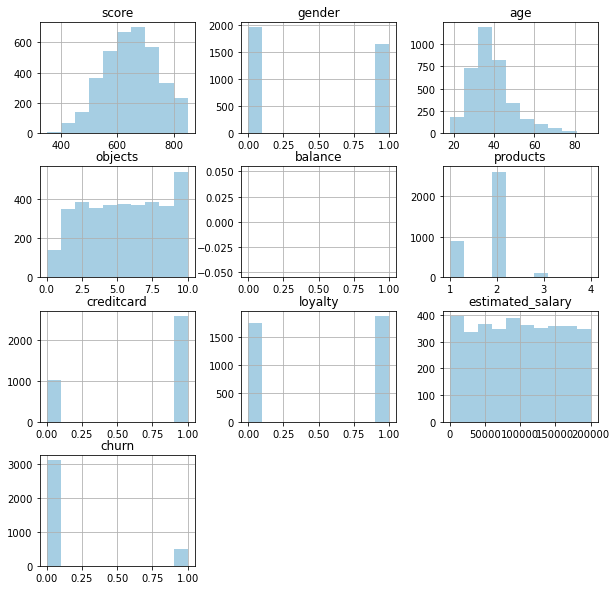

In [19]:
df[df['balance']!=df['balance']].drop('userid', axis=1).hist(figsize = (10,10));

In [20]:
# клиенты без записей о балансе в зависимости от города, где находится банк
df[df['balance']!=df['balance']]['city'].value_counts(normalize=True)

Ярославль   0.67
Рыбинск     0.33
Name: city, dtype: float64

In [21]:
# клиенты без записей о балансе в зависимости от количества продуктов в пользовании
df[df['balance']!=df['balance']]['products'].value_counts(normalize=True)

2   0.72
1   0.25
3   0.03
4   0.00
Name: products, dtype: float64

In [22]:
# все клиенты в зависимости от количества продуктов в пользовании
df['products'].value_counts(normalize=True)

1   0.51
2   0.46
3   0.03
4   0.01
Name: products, dtype: float64

Характерики клиентов, у которых отсутствует баланс схожи с общими характеристиками клиентов банка, при этом 
- среди них немного меньше тех, кто ушел
- у них больше продуктов в пользовании: 72% имеют 2 продукта, тогда как по всем клиентам их 46%
- среди них нет жителей Ростова Великого

Скорее всего отсутствие баланса связано с ошибкой выгрузки. Мы не можем заменить пропуски на нули или средний баланс. Это может исказить наши данные, ососбенно учитывая нашу задачу по сегментации т.к. среди клиентов без записей о балансе бОльшая доля потребителей 2х продуктов.

### Матрица корреляций признаков
- между какими признаками есть корреляция

In [23]:
# скопируем датасет, там создадим новый столбец, закодировав города, а старый столбец превратим в дамми-переменные
df_cor=df
df_cor['city_coded'] = df_cor['city'].map({'Ростов Великий': 0, 'Рыбинск': 1, 'Ярославль': 2})
df_cor=pd.get_dummies(df_cor)
df_cor

,userid,score,gender,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn,city_coded,city_Ростов Великий,city_Рыбинск,city_Ярославль
0,15677338,619,1,42,2,NaN,1,1,1,101348.88,1,2,0,0,1
1,15690047,608,1,41,1,83807.86,1,0,1,112542.58,0,1,0,1,0
2,15662040,502,1,42,8,159660.80,3,1,0,113931.57,1,2,0,0,1
3,15744090,699,1,39,1,NaN,2,0,0,93826.63,0,2,0,0,1
4,15780624,850,1,43,2,125510.82,1,1,1,79084.10,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,15648965,771,0,39,5,NaN,2,1,0,96270.64,0,2,0,0,1
9996,15612628,516,0,35,10,57369.61,1,1,1,101699.77,0,2,0,0,1
9997,15627268,709,1,36,7,NaN,1,0,1,42085.58,1,2,0,0,1
9998,15725091,772,0,42,3,75075.31,2,1,0,92888.52,1,0,1,0,0


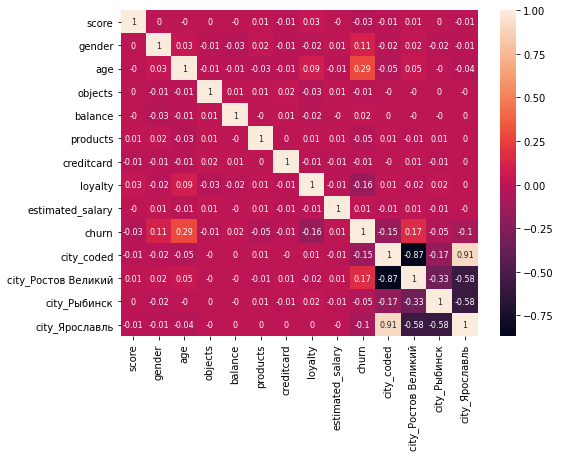

In [24]:
cm = df_cor.drop('userid', axis=1).corr().round(2)
# нарисуем тепловую карту для матрицы корреляций
plt.figure(figsize=(8,6))  
sns.heatmap(cm, annot = True, annot_kws = {'size':8});

На тепловой карте для матрицы корреляций Пирсона мы не наблюдаем сильных связей. Корреляция около 0.3 наблюдается между оттоком и возрастом. Мы можем предполагать, что чем больше возраст, тем больше отток и взять это на заметку для рекомендаций для пенсионеров, например.Также можем заметить корреляцию -0.16 между оттоком и активностью (меньше активность - больше отток).

Посмотрим матрицу корреляций Phik (𝜙k).
Phik (𝜙k) - это коэффициент корреляции, который последовательно работает между категориальными, порядковыми и интервальными переменными, фиксирует нелинейную зависимость и возвращается к коэффициенту корреляции Пирсона в случае двумерного нормального входного распределения (https://towardsdatascience.com/phik-k-get-familiar-with-the-latest-correlation-coefficient-9ba0032b37e7). Заметим, что коэффициент имеет значения от 0 до 1, чем ближе к 1, тем сильнее связь.

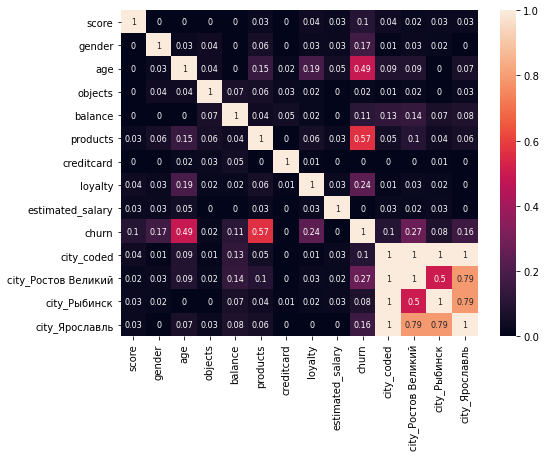

In [25]:
interval_cols= ['score', 'age', 'objects', 'balance', 'products', 'estimated_salary']
phik = df_cor.drop('userid', axis=1).phik_matrix(interval_cols=interval_cols).round(2)

plt.figure(figsize=(8,6))  
sns.heatmap(phik, annot = True, annot_kws = {'size':8});

Мы наблюдаем снова связь возраста и оттока, но и появились новые связи.

Это количество продуктов и отток, 0.57, - связь явно выраженная, однако не обязательно положительно направленная (коэффициент всегда больше нуля). Также есть корреляция 0.24 между оттоком и активностью и 0.15 между количеством продуктов и возрастом. Для будущей сегментации для нас особенно важны связи количества продуктов с оттоком и возрастом.

## Сегментируйте пользователей на основе данных о количестве потребляемых продуктов

### Сегментация пользователей по количеству продуктов
- Варианты сегметации (один продукт и больше одного, или один, два и три и более продуктов)

In [26]:
df=df.drop('city_coded', axis=1)

In [27]:
df['products'].value_counts().sort_values(ascending=False)

1    5084
2    4590
3     266
4      60
Name: products, dtype: int64

In [28]:
df['products'].value_counts(normalize=True).sort_values(ascending=False)

1   0.51
2   0.46
3   0.03
4   0.01
Name: products, dtype: float64

Чуть более половины всех клиентов, 51%, пользуется одним продуктом банка, 46% двумя, около 3% тремя и меньше 1% (60 человек) - четырьмя продуктами. Таким образом, мы можем сегментировать клиентов на тех, кто потребляет один продукт, и тех, кто потребляет более одного продукта, и тогда группы будут примерно равные по размеру. Также, мы можем поделить клиентов на три сегмента, и отдельно взглянуть на характеристики потребителей трех и более продуктов. 

Для этого создадим новые столбцы, prod_segment, где 0 - один продукт и 1 - больше одного, и prod_segment_extra, где где 0 - один продукт и 1 - 2 продукта и 2 - более 2.

In [29]:
# добавим два столбца с обоими вариантами сегментации
df['prod_segment'] = df['products'].map({1: 0, 2:1, 3:1, 4:1})
df['prod_segment_extra'] = df['products'].map({1: 0, 2:1, 3:2, 4:2})

### Средние значения признаков в группах по потреблению и выбор наиболее удачного варианта сегментации для дальнейшей работы

Сравним средние значения признаков в обоих вариантах сегментации.

In [30]:
prod_segment_means=df.drop(
    ['userid','products','prod_segment_extra'], axis = 1).groupby(
    'prod_segment').agg(['mean'])

In [32]:
prod_segment_means.columns = ['скоринг', 'пол', 'возраст', 'объекты', 'балланс', 'карта', 'активность', 'зарплата', 'отток']

In [33]:

prod_segment_means.columns = ['скоринг', 'пол', 'возраст', 'объекты', 'балланс', 'карта', 'активность', 'зарплата', 'отток']
prod_segment_means=prod_segment_means.T
prod_segment_means.columns = ['1 продукт', '2 и более продуктов']
prod_segment_means.style.background_gradient(cmap='Blues', axis=1).format('{:.2f}')

,1 продукт,2 и более продуктов
скоринг,649.12,651.98
пол,0.45,0.46
возраст,39.67,38.14
объекты,4.97,5.05
балланс,119894.16,119701.08
карта,0.70,0.71
активность,0.50,0.53
зарплата,99487.26,100713.83
отток,0.28,0.13


In [34]:
prod_segment_extra_means=df.drop(
    ['userid','products','prod_segment'], axis = 1).groupby(
    'prod_segment_extra').agg(['mean'])
prod_segment_extra_means.columns = ['скоринг', 'пол', 'возраст', 'объекты', 'балланс', 'карта', 'активность', 'зарплата', 'отток']
prod_segment_extra_means=prod_segment_extra_means.T
prod_segment_extra_means.columns = ['1 продукт', '2 продукта', '3 и более продуктов' ] 
prod_segment_extra_means.style.background_gradient(cmap='Blues', axis=1).format('{:.2f}')

,1 продукт,2 продукта,3 и более продуктов
скоринг,649.12,652.19,649.11
пол,0.45,0.45,0.57
возраст,39.67,37.75,43.65
объекты,4.97,5.05,5.06
балланс,119894.16,119660.94,120074.31
карта,0.70,0.71,0.71
активность,0.50,0.53,0.44
зарплата,99487.26,100452.01,104400.14
отток,0.28,0.08,0.86


Сравнивая таблицы средних значений в наших вариантах разбивки, мы можем сделать вывод, что сегментирование на 3 группы обнаруживает больше различий, и дает увидеть, что клиенты с тремя и более продуктами существенно отличаются от остальных, в том числе от тех у кого два продукта. Будем считать такое разбиение более удачным, и далее будем разбивать клиентов на три группы по потреблению и взглянем на распределения. 

### Портреты пользователей в группах по потреблению и основные различия между сегментами 
- Распределения признаков в группах по потреблению продуктов. Графики
- Описание и характеристики сегментов пользователей по потреблению
- Связь между количеством потребляемых продуктов и оттоком
- Связь между количеством потребляемых продуктов и наличием кредитной карты
- Связь между количеством потребляемых продуктов и местонахождением филиала

In [35]:
interval_cols = ['score', 'age', 'objects', 'balance', 'estimated_salary']
binar_cols = ['gender','creditcard', 'loyalty', 'churn','city']

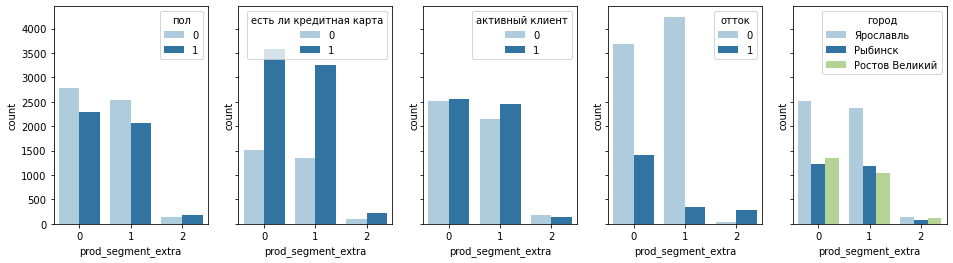

In [36]:
# распределения для бинарных переменных и города
title_name=['пол', 'есть ли кредитная карта', 'активный клиент', 'отток', 'город' ]
#labels=["AAA","BBB"]

_, axes = plt.subplots(1, 5, sharey=True, figsize=(16,4) )
i=0
   
for parametr in binar_cols:
    sns.countplot(hue=parametr, x=('prod_segment_extra'), data=df, ax=axes[i]).legend(title = title_name[i])
    i=i+1

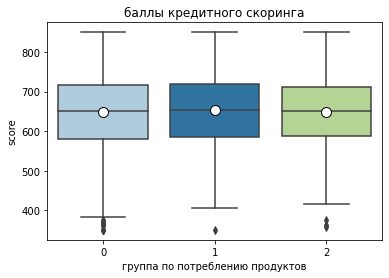

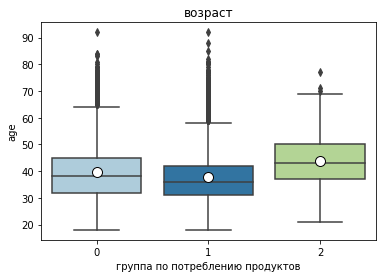

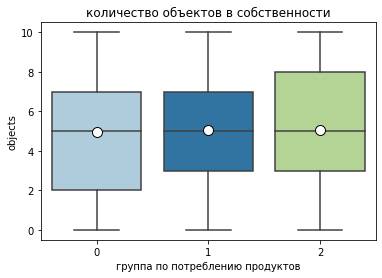

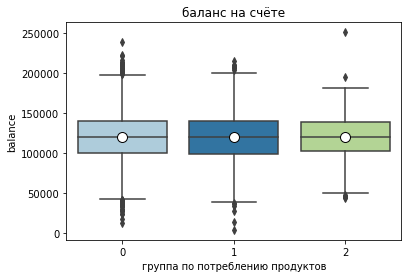

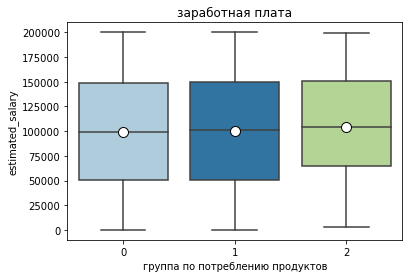

In [37]:
# распределения для интервальных переменных
title_name=['баллы кредитного скоринга', 'возраст', 'количество объектов в собственности', 'баланс на счёте', 'заработная плата' ]
interval_cols = ['score', 'age', 'objects', 'balance', 'estimated_salary']

i=0
for parametr in interval_cols:
    
    sns.boxplot(x='prod_segment_extra', y=parametr, data=df, showmeans=True, meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"}).set_title(title_name[i])
    plt.ylabel(parametr)
    plt.xlabel("группа по потреблению продуктов")
    plt.show()
    i=i+1

Анализируя таблицу со средними по трем сегментам и графики распределений, зафиксируем следующие выводы:
- Пол. Среди потребителей 3-х и более продуктов, доля женщин больше, чем в других сегментах (на 12%).
- Возраст. Те у кого 2 продукта несколько помоложе тех, у кого 1 продукт (38 против 40). Обладатели 3х и более продуктов старше - им в среднем 44 года.
- Активность. Среди потребителей 2-х и более продуктов активность выше на 3% по сравнению с теми, у кого 1 продукт (их средняя активность 50%), а вот у обладателей 3-х и более продуктов активность самая низкая, почти на 10% ниже чем у тех, у кого их 2
- Баланс. баланс в сегментах почти одинаковый, однако вспомним, что среди обладателей 2-х продуктов было много пропусков по балансу, а именно 57%, то есть в более чем половине случаев. 
- Отток. В группе с 1 продуктом процент по оттоку выше, чем у тех, у кого 2 продукта на 20% (28% против 8%). Однако в группе пользователей 3-х и более продуктов отток очень высокий - 86%. Вполне вероятно, что отток связан с пользовательским опытом какого-то конкретного банковского продукта. Для дальнейшего исследования причин оттока необходимо знать, какие именно продукты помимо банковской карты были в распоряжении пользователей. Пока же, для продвижения продуктов среди пользователей мы можем порекомендовать сосредоточиться на первой группе - тех, у кого один продукт в распоряжении, поставив как цель, чтобы такие пользователи обзавелись вторым продуктом, что поможет снизить вероятность оттока. Группа с 3мя продуктами должна быть изучена отдельно, - это группа повышенного риска в плане оттока.
- По кредитному скору и зарплате разница в группах незначительна.

In [38]:
# доля обладателей кредитных карт по количеству продуктов в пользовании
df.groupby('prod_segment_extra')['creditcard'].agg(['count', 'mean']) 

,count,mean
prod_segment_extra,,
0,5084,0.70
1,4590,0.71
2,326,0.71


Доля владельцев кредитной карты в каждой группе по количеству потребляемых продуктов практически одинакова, - около 70%, интересно, что она не растет с количеством потребляемых продуктов. Т.е. среди тех, у кого 3 или 4 продукта банка, также 30% без кредитных карт. Посмотрим повнимательнее на характеристики тех, у кого нет продукта - кредитной карты, чтобы понять аудиторию.

In [39]:
df[df['creditcard']==0].describe().T.drop('userid').drop('count', axis=1)

,mean,std,min,25%,50%,75%,max
score,651.35,96.64,350.00,581.00,654.00,718.00,850.00
gender,0.46,0.50,0.00,0.00,0.00,1.00,1.00
age,39.11,10.53,18.00,32.00,38.00,44.00,92.00
objects,4.91,2.93,0.00,2.00,5.00,7.00,10.00
balance,119519.12,30226.53,12459.19,99416.12,118678.10,139032.70,250898.09
products,1.53,0.58,1.00,1.00,1.00,2.00,4.00
creditcard,0.00,0.00,0.00,0.00,0.00,0.00,0.00
loyalty,0.52,0.50,0.00,0.00,1.00,1.00,1.00
estimated_salary,100974.40,57761.34,90.07,52193.23,101617.43,149991.32,199992.48
churn,0.21,0.41,0.00,0.00,0.00,0.00,1.00


Общие характеристики практически не отличаются от всей совокупности клиентов ни по одному из признаков.

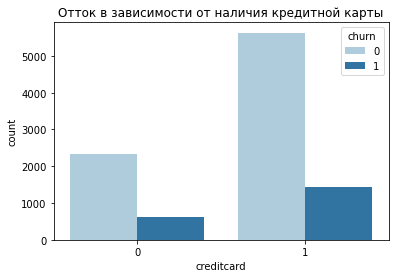

In [40]:
sns.countplot(hue='churn', x='creditcard', data=df)
plt.title('Отток в зависимости от наличия кредитной карты');

In [41]:
df.groupby(['creditcard'])[('churn')].agg(['mean'])

,mean
creditcard,
0,0.21
1,0.20


In [42]:
df.groupby(['creditcard', 'prod_segment_extra'])[('churn')].agg(['mean'])

mean
creditcard prod_segment_extra      
0          0                   0.28
           1                   0.08
           2                   0.87
1          0                   0.28
           1                   0.07
           2                   0.85

Что касается оттока, то кажется, что наличие кредитной карты не связано с оттоком - доли оттока примерно равные.

Таким образом, добавим в выводам по сегментам:
- Кредитная карта. Среди потребителей по группам нет разницы, у всех доля 70%. Это немного противоречит интуитивным предположением - чем больше продуктов у человека, тем больше вероятность, что у него среди продуктов будет кредитная карта. Однако, это не так.

In [43]:
prod_city = pd.crosstab(df['city'], df['prod_segment_extra'])
prod_city.columns = ['1_product', '2_products', '>=3_products'] 
prod_city['1_product%'] = prod_city['1_product']/ prod_city['1_product'].sum()*100
prod_city['2_products%'] =  prod_city['2_products']/ prod_city['2_products'].sum()*100
prod_city['3_products%'] = prod_city['>=3_products']/ prod_city['>=3_products'].sum()*100
prod_city.drop(['1_product', '2_products', '>=3_products'], axis=1).style.background_gradient(cmap='Blues', axis=1).format('{:.2f}')

,1_product%,2_products%,3_products%
city,,,
Ростов Великий,26.53,22.66,36.81
Рыбинск,24.02,25.77,22.39
Ярославль,49.45,51.57,40.80


In [44]:
prod_city = pd.crosstab(df['city'], df['prod_segment_extra'])
prod_city.columns = ['1_product', '2_products', '>=3_products'] 
prod_city=prod_city.T

In [45]:
prod_city['Ростов Великий%'] = prod_city['Ростов Великий']/ prod_city['Ростов Великий'].sum()*100
prod_city['Рыбинск%'] =  prod_city['Рыбинск']/ prod_city['Рыбинск'].sum()*100
prod_city['Ярославль%'] = prod_city['Ярославль']/ prod_city['Ярославль'].sum()*100
prod_city=prod_city.drop(['Ростов Великий', 'Рыбинск', 'Ярославль'], axis=1)
prod_city.T.style.background_gradient(cmap='Blues').format('{:.2f}')

,1_product,2_products,>=3_products
city,,,
Ростов Великий%,53.77,41.45,4.78
Рыбинск%,49.29,47.76,2.95
Ярославль%,50.14,47.21,2.65


In [46]:
# вспомним распределение клиентов по городам
df['city'].value_counts(normalize=True)

Ярославль        0.50
Ростов Великий   0.25
Рыбинск          0.25
Name: city, dtype: float64

In [47]:
# посмотрим распределение оттока по городам и количеству потребляемых продуков
df.groupby(['city', 'prod_segment_extra'])[('churn')].agg(['mean']).style.background_gradient(
    cmap='Blues').format('{:.2f}')

Вспомним, что половина всех клиентов из Ярославля, и по четверти из Ростова и Рыбинска. Однако по продуктовым сегментов соотношение клиентов иное. В Ростове Великом клиентов по двум продуктам их немного меньше, 23% (а не 25%). А вот по трем и более продуктам ростовское присутствие намного выше их "квоты" в четверть и достигает 37%. Ярославское же, наоборот, падает на 10%. Среди обладателей множества продуктов их 40%, а не половина как в целом по клиентам.
- По одному продукту в Ростове доля клиентов чуть выше чем 25% в общем числу, а именно 27%
- В Ростове больше доля клиентов с одним продуктом, чем в остальных городах (54% от всех ростовчан, в то время как в Рыбинске 49% а в Ярославле 50%.
- Доля клиентов с двумя продуктами у Рыбинска и Ярославля около 47% от всех по городу, а у Ростова ниже - 42%.
- Среди тех, у кого три продукта, доля ростовчан наоборот больше - 5% от всех клиентов по городу против 3% в Рыбинске и Ярославле. 
Таким образом в Ростове немного иное соотношение по продуктовым сегментам - там меньше тех, у кого два продукта (а это более стабильная по оттоку категория клиентов) и больше тех, у кого один продукт и у кого три продукта (но их число мало и они риск для оттока). Поэтому Ростовский филиал требует особого внимания. Там в целом намного выше уровень оттока по клиентам, на 20% выше, чем в остальных филиалах по клиентам с одним продуктом (43%) и на 10% выше по трем продуктам (92% клиентов с 3 продуктами из Ростова - отток против 81-23% в остальных).
Наша цель должна быть - повысить долю клиентов с двумя продуктами, и очень внимательно отнестись к тем, у кого много продуктов, т.к. они в большинстве своем попадают в отток, особенно - в Ростовском филиале.

## Проверка статистических гипотез

### Проверка гипотезы различия дохода между теми клиентами, которые пользуются двумя продуктами банка, и теми, которые пользуются одним

Здесь мы проверим, есть ли разница между доходом клиентов, которые пользуются одним продуктом банка, и теми, которые пользуются двумя, и имеет ли эта разница статистическую значимость.

Нулевая гипотеза, которую мы будем проверять: нет статистически значимого различия между доходами таких клиентов. По сути это проверка гипотезы о равенстве средних.

Посмотрим на распределение данных о доходе среди групп клиентов по потреблению.

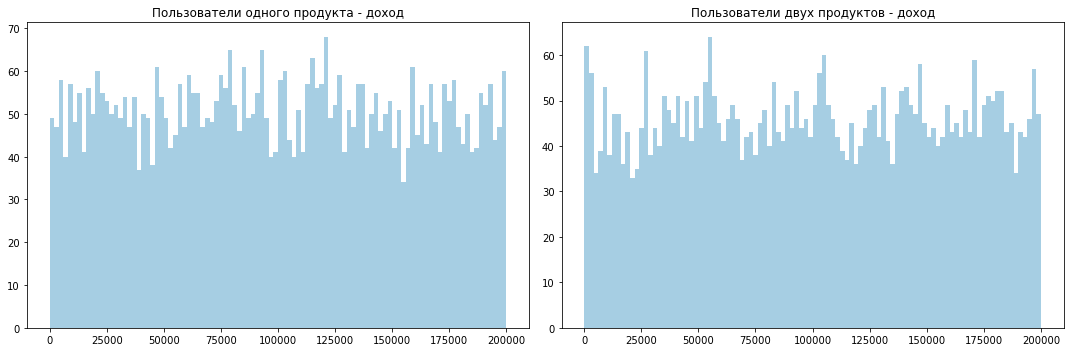

In [48]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

ax[0].set_title('Пользователи одного продукта - доход')
ax[0].hist(df[df['products']==1]['estimated_salary'], bins=100)

ax[1].set_title('Пользователи двух продуктов - доход')
ax[1].hist(df[df['products']==2]['estimated_salary'], bins=100)
fig.tight_layout()

Заметим, что чтобы применить t-test, данные не обязательно должны быть распределены нормально. Нормально должен быть распределен параметр (среднее), а это выполняется по ЦПТ для достаточно больших выборок. T-test следует использовать тогда, когда среднее – это хорошая описательная статистика для популяции, а в нашем случае так и есть. 

Тем не менее, проиллюстрируем распределение выборочных средних по зарплате для каждой из групп по продуктам.

In [49]:
means_a = []
means_b = []

df_a = df[df['products']==1]
df_b = df[df['products']==2]

len_a = len(df_a)
len_b = len(df_b)

# сгенерируем случайные выборки для каждой из групп и посмотрим на распределение их средних

for _ in tqdm(range(10000)):
    sample_a = np.random.choice(df_a['estimated_salary'], size=len_a, replace=True)
    sample_b = np.random.choice(df_b['estimated_salary'], size=len_b, replace=True)
    means_a.append(sample_a.mean())
    means_b.append(sample_b.mean())

100%|██████████| 10000/10000 [00:01<00:00, 5208.51it/s]


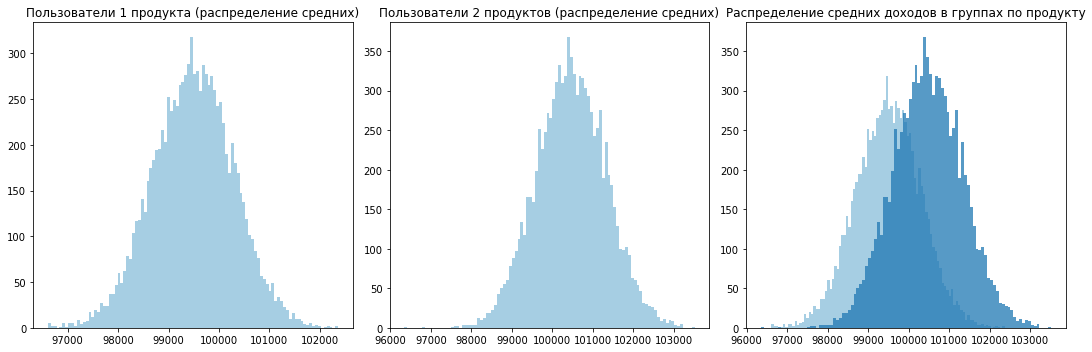

In [50]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

ax[0].set_title('Пользователи 1 продукта (распределение средних)')
ax[0].hist(means_a, bins=100)

ax[1].set_title('Пользователи 2 продуктов (распределение средних)')
ax[1].hist(means_b, bins=100)

ax[2].set_title('Распределение средних доходов в группах по продукту')
ax[2].hist(means_a, bins=100)
ax[2].hist(means_b, bins=100, alpha=0.75)

fig.tight_layout()

Как видно, распределение средних напоминает нормальное, можем применить t-test. На третьем графике мы можем заметить, что средние средних в обоих группах близко, и, похоже, что средние по доходам в обоих группах мало различаются. Чтобы понять, является ли такое различие статистически значимым, проведем  t-test.

In [56]:
alpha = 0.05  # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(df_a['estimated_salary'], df_b['estimated_salary'], equal_var=False)

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-value: 0.4106493940071987
Не получилось отвергнуть нулевую гипотезу


По результатам теста мы не можем отвершнуть нулевую гипотезу о равенстве средних, p-value получилось большим, то есть в 41% случаев такая разница в средних зарплатах могла быть случайной.

Таким образом, мы не можем сказать, что есть статистически значимое различие между доходами клиентов, которые пользуются одним продуктом, и теми, кто пользуется двумя продуктами. 

В практическом смысле это означает, что, например, для продвижение продуктов в группе пользователей с одним продуктом, нам не стоит ориентироваться на доход и связывать с ним стратегии продвижения для этой группы. Проще говоря: те, у кого один продукт в среднем не богаче и не беднее тех, у кого два продукта.

### Проверка второй гипотезы различия возраста между теми клиентами, которые пользуются двумя продуктами банка, и теми, которые пользуются одним.

Здесь мы проверим, есть ли значимые отличия по возрасту между теми, кто пользуется одним продуктом банка, и теми, кто пользуется двумя. Заметим, что исходя из среднего и графиков, мы сделали вывод, что старше. Но является ли эта разница статистически значимой?

Нулевая гипотеза, которую мы будем проверять: нет статистически значимого различия между возрастами таких клиентов.

Посмотрим на распределение данных о возрасте среди групп клиентов по потреблению.

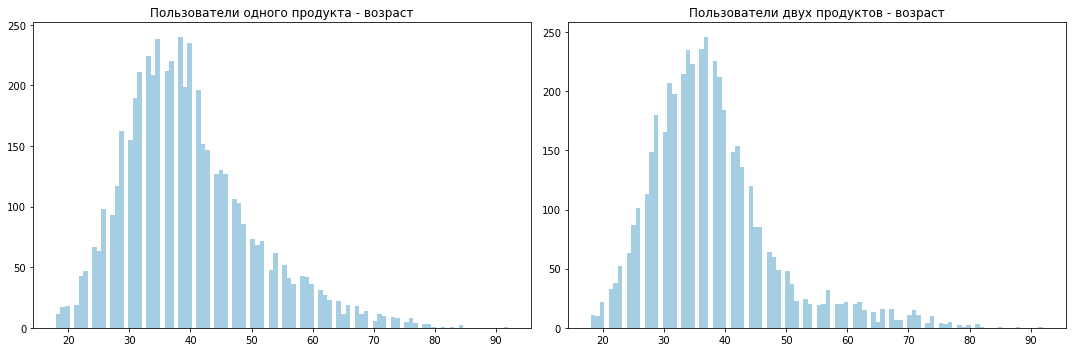

In [52]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

ax[0].set_title('Пользователи одного продукта - возраст')
ax[0].hist(df[df['products']==1]['age'], bins=100)

ax[1].set_title('Пользователи двух продуктов - возраст')
ax[1].hist(df[df['products']==2]['age'], bins=100)
fig.tight_layout()

По аналогии с предыдущей проверкой гипотезы, проиллюстрируем распределение выборочных средних по возрасту для каждой из групп по продуктам.

In [53]:
means_a = []
means_b = []

df_a = df[df['products']==1]
df_b = df[df['products']==2]

len_a = len(df_a)
len_b = len(df_b)

for _ in tqdm(range(10000)):
    sample_a = np.random.choice(df_a['age'], size=len_a, replace=True)
    sample_b = np.random.choice(df_b['age'], size=len_b, replace=True)
    means_a.append(sample_a.mean())
    means_b.append(sample_b.mean())

100%|██████████| 10000/10000 [00:01<00:00, 5079.36it/s]


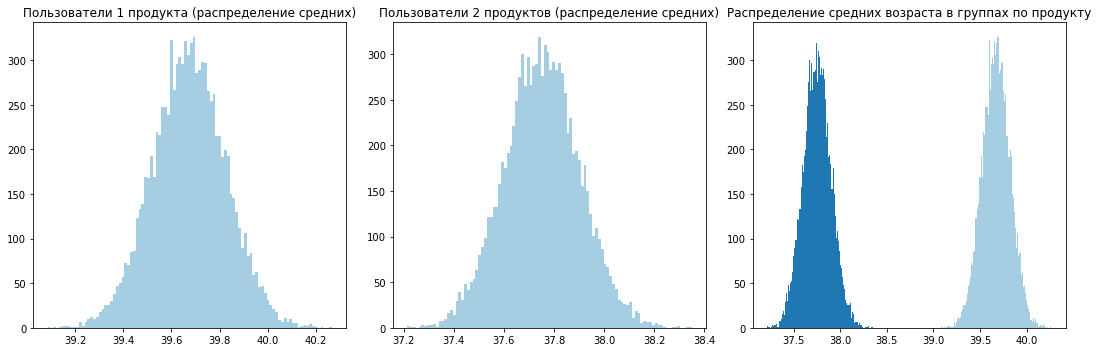

In [54]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

ax[0].set_title('Пользователи 1 продукта (распределение средних)')
ax[0].hist(means_a, bins=100)

ax[1].set_title('Пользователи 2 продуктов (распределение средних)')
ax[1].hist(means_b, bins=100)

ax[2].set_title('Распределение средних возраста в группах по продукту')
ax[2].hist(means_a, bins=100)
ax[2].hist(means_b, bins=100)

fig.tight_layout()

Распределение средних снова напоминает нормальное, можем применить t-test. 
Однако, здесь на третьем графике мы видим совсем другую картину: графики вообще не пересекаются, средние средних в обоих группах  далеки. Похоже, что средний возраст в группах знаяимо отличчается.

Посмотрим, является ли такое различие статистически значимым, проведем t-test.

In [59]:
alpha = 0.05  # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(df_a['age'], df_b['age'], equal_var=False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 1.4069637543991388e-19
Отвергаем нулевую гипотезу


Получилось, что p-значение очень мало. Мы можем утверждать, что разница есть, и что пользователи с одним продуктом старше, чем те, что с двумя. В практическом плане это означает, что для работы по продвижению продуктов в этих группах, необходимо учитывать возраст. Клиентом с одним продуктом следует предлагать продукты, которые могут быть интересны чуть более старшему возрасту (пенсионный план, например).

попробуй пофантазировать на тему того какие продукты могут быть интересны различным категориям клиентов. Среди банковских продуктов могут быть дебетовые и кредитные карты, кредит наличными и ипотека, зарплатные и пенсионные проекты, инвестиционные и накопительные счета и тд. Посмотри какая аудитория в каждом из продуктовых сегментов и сделай релевантные рекомендации на основании этих продуктов. Подумай какой из продуктов способен в долгосрочной перспективе удержать клиентов.

##  Выводы

### Общий портрет клиента банка

- Примерно поровну клиентов обоих полов 
- Возраст от 18 до 92 лет. Средний возраст 39 лет. 
- Половина наших клиентов имеет в пользовании только один продукт, 46% двумя, около 3% тремя и меньше 1% - четырьмя продуктами. 
- 71 % клиентов обладают кредитной картой
- 52 % клиентов являются активными 
- В среднем в собственности 5 объектов, минимум 0, максимум 10
- Средний балл кредитного скоринга 650, при этом минимум 350 и максимум 850
- 20% клиентов - отток
- Средняя заработная плата клиента 100 000
- Половина клиентов из Ярославля, по четверти из Ростова Великого и Новгорода
- Средний баланс на счету у клиентов 120 000 
- У 36% клиентов из датасета отсутствует информация о балансе
    - среди них немного меньше оттока
    - у них больше продуктов в пользовании
    - среди них нет жителей Ростова Великого

### Связи характеристик
- возраст и отток
- активность и отток
- количество продуктов и отток
- количеством продуктов и возраст

### Сегментация клиентов по количеству продуктов
- сегментирование на 3 группы - один, два и три и больше продуктов,  обнаруживает больше различий чем деление на две группы
- клиенты с тремя и более продуктами существенно отличаются от остальных, в том числе от тех у кого два продукта. 

###  Портреты клиентов в группах по количеству продуктов и основные различия 

- Пол. Среди потребителей 3-х и более продуктов, доля женщин больше, чем в других сегментах (на 12%).
- Возраст. Те у кого 2 продукта несколько помоложе тех (38 лет), у кого 1 продукт (40). Обладатели 3х и более продуктов старше - им в среднем 44 года.
- Активность. Среди потребителей 2-х и более продуктов активность выше на 3% по сравнению с теми, у кого 1 продукт (средняя активность 50%), у обладателей 3-х и более продуктов активность самая низкая, почти на 10% ниже чем у тех, у кого 2 продукта
- Отток. В группе с 1 продуктом отток выше, чем у тех, у кого 2 продукта на 20% (28% против 8%). В группе пользователей 3-х и более продуктов отток очень высокий - 86%. 
- Баланс. Почти одинаковый во всех группах. Но среди обладателей 2-х продуктов 57% пропусков по балансу
- По кредитному скору и зарплате разница в группах незначительна
- Кредитная карта. Среди групп доля обладателей карт одинаковая - около 70%. 
- Отток. В группе с 1 продуктом отток выше, чем у тех, у кого 2 продукта на 20% (28% против 8%). В группе пользователей 3-х и более продуктов отток очень высокий - 86%.
- Город. В Ростове немного иное соотношение по продуктовым сегментам, чем в Ярославле и Рыбинске - там меньше тех, у кого два продукта (а это более стабильная по оттоку категория клиентов), больше тех, у кого один продукт и у кого три продукта (но их число мало и они риск для оттока)

### Проверка гипотез
- Нельзя утверждать, что есть статистически значимое различие между доходами клиентов, которые пользуются одним продуктом, и теми, кто пользуется двумя продуктами
- Можно утверждать, что есть разница в возрасте среди групп клиентов по потреблению банковских продуктов (один и два продукта). пользователи с одним продуктом старше, чем те, что с двумя. 

## Рекомендации по работе с клиентами

- Исследовать причины оттока в зависимости от продуктов, для клиентов с тремя и более продуктами т.к. у них чрезвычайно высокая доля оттока. До такого исследования, чтобы избежать риск оттока, сосредоточиться на тех, у кого один продукт в распоряжении

- Повысить долю клиентов с двумя продуктами, это поможет снизить вероятность оттока

- Кредитные карты. Повысить долю клиентов, которые пользуются кредитными банковскими картами. Банковские карты это самый востребованный продукт, они есть у 70% клиентов. Тем 30% клиентов, которые имеют один продукт и это не карта, мы можем предложить карту со специальными условиями обслуживания, с кэшбеком, со специальными акциями или бонусами (как, например,накопительные мили). 

- Возраст одна из центральных характеристик, на которую нужно обратить внимание при продвижении продуктов клиентов банка. Клиенты с одним продуктом старше, поэтому необходимо предложить им продукты и услуги, интерес к которым может быть обусловлен возрастом. Например, вклады и накопительные счета. 
- Предложить инвестиционные продукты для пожилых людей, такие как индивидуальный пенсионный план, пенсионный инвестиционный счет. Стимулировать увеличение количества клиентов, которые получают свою пенсию на счет в банке через пенсионные карты с кэшбеком или процентами на остаток по счету. Разработать специальные кредитные предложения для людей старшего возраста.

- Также можно задуматься о партнерстве с розничными сетями и запустить кобрендинговые карты, которые дают бонусы и привилегии в сетях. Необходимо учесть, какие сети могут быть актуальны для более старшего сегмента клиентов.

- Активность снижает вероятность оттока и может положительно повлиять на увеличение продуктов в пользовании. Стимулировать активность пользователей, например, посредством внедрения удобного и упрощенного мобильного приложения или предлагая систему быстрых платежей.

- Уделить особое внимание Ростовскому филиалу. Там в целом намного выше уровень оттока по клиентам, и гораздо больше доля клиентов у которых только один продукт. Посмотреть, есть ли какие-то клиентские нужды, специфические для этого города.

## Презентация

https://drive.google.com/file/d/1ppdIvQO1nCkYp4RubDP4jct_NeLvpuk0/view?usp=sharing

## Дашборд

https://public.tableau.com/app/profile/elena.lebedeva/viz/Banking_16370224254770/Dashboard1